In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import scipy.optimize
import numpy as np

import warnings
warnings.filterwarnings("ignore")

# CAVEAT

THIS NOTEBOOK IS JUST AN EXAMPLE OF CURVE FITTING ON SOME REAL WORD DATA.

PLEASE REFRAIN TO TAKE ANY DECISION OR TO EXTRAPOLATE ANY RECOMMANDATION BASED ON THIS NOTEBOOK.

**PLEASE STICK TO OFFICIAL RECOMMENDATION AND INFORMATION!**

* https://www.who.int/emergencies/diseases/novel-coronavirus-2019

# Load the data provided by JHU 

In [2]:
# Data source: https://github.com/CSSEGISandData/COVID-19
!cd DATA && git pull && cd ../

Already up to date.


In [3]:
df_confirmed = pd.read_csv('DATA/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')

In [4]:
# Drop data from 2020-03-12 because for many country data for this day was a replica from the previous day.
df_confirmed.drop(columns=['3/12/20'], inplace=True)

In [5]:
# Pivot the data: wide to long
df_confirmed_pivoted = df_confirmed.set_index(['Province/State', 'Country/Region', 'Lat', 'Long']).stack().to_frame('Cases').reset_index()
df_confirmed_pivoted = df_confirmed_pivoted.rename(columns={'level_4' : 'Date'})
df_confirmed_pivoted['Date'] = pd.to_datetime(df_confirmed_pivoted['Date'])
df_confirmed_pivoted = df_confirmed_pivoted.groupby(['Country/Region','Date'])['Cases'].sum().to_frame('Cases').reset_index()

# Models and other amenities

In [6]:
# Exponential model
def exponential_model(x, *pars): 
    return pars[0]+np.exp(pars[1]*x+pars[2])
# Logistic model
def logistic_model(x, *pars): 
    return pars[0]+pars[1]/(1+np.exp(-pars[2]*(x-pars[3])))

def fit_model(xdata, ydata, model, p0=[1,1,1]):

    popt, pcov = scipy.optimize.curve_fit(model, xdata, ydata,
                                          p0=p0, 
                                          method='trf',
                                          absolute_sigma=False,
                                          max_nfev=50000)

    r_square = 1 - np.square(ydata-model(xdata, *popt)).sum() / np.var(ydata)
    
    return popt, pcov, r_square

def print_fit_results(popt, pcov, r_square):
    
    print('Fit Parameters:')
    print(popt)
    print()
    print('Covariance matrix:')
    print(pcov)
    print()
    print('R-square: %.3f'% r_square)

def forecast(start_date, start_day, n_days, model, popt, pcov):
    
    index = np.arange(start_day, start_day+n_days)
    
    perr = np.sqrt(np.diag(pcov))
    
    df = pd.DataFrame(
        index=index,
        data={
            'Date': pd.date_range(start=start_date, periods=n_days),
            'Forecast' : model(index, *popt),
            'Forecast_sup' : model(index, *(popt+perr)),
            'Forecast_inf' : model(index, *(popt-perr)),
         }
    )
    
    df['Uncertainty'] = df['Forecast_sup'] - df['Forecast_inf']

    return df
    
def predict(dates, days, model, popt, pcov):
    
    perr = np.sqrt(np.diag(pcov))
    
    df = pd.DataFrame(
        data={
            'Date': dates,
            'Model' : model(days, *popt),
            'Model_sup' : model(days, *(popt+perr)),
            'Model_inf' : model(days, *(popt-perr)),
         }
    )
    
    df['Uncertainty'] = df['Model_sup'] - df['Model_inf']

    return df

# Fit data for Italy

In [9]:
# The same fit works for other country, but the intitial fit parameters must be carefully tuned
dfit = df_confirmed_pivoted.loc[df_confirmed_pivoted['Country/Region'] == 'Italy'].reset_index(drop=True)
dfit = dfit.loc[dfit['Cases'] > 0]

dfit['ndays'] = (dfit['Date'] - dfit['Date'].iloc[0]).dt.days

ydata=dfit['Cases'] 
xdata=dfit['ndays']

# Logistic model
print()
print('-----------------')
print('Logistic model')
print('-----------------')
print()
p0=[-7.89564887e+01, 4.57770247e+04,  2.26454719e-01,  5.34455732e+01]
popt, pcov, r_square_logit = fit_model(xdata,ydata,logistic_model, p0=p0)
print_fit_results(popt, pcov, r_square_logit)
df_predict_logit = predict(dfit['Date'].values, dfit['ndays'].values, logistic_model, popt, pcov)
df_forecast_logit = forecast(dfit['Date'].values[-1], dfit['ndays'].values[-1], 30, logistic_model, popt, pcov)

# Exponential model
print()
print('-----------------')
print('Exponential model')
print('-----------------')
print()
p0=[1,1,1]
popt, pcov, r_square_exp = fit_model(xdata, ydata, exponential_model, p0=p0)
print_fit_results(popt, pcov, r_square_exp)
df_predict_exp = predict(dfit['Date'].values, dfit['ndays'].values, exponential_model, popt, pcov)
df_forecast_exp = forecast(dfit['Date'].values[-1], dfit['ndays'].values[-1], 10, exponential_model, popt, pcov)


-----------------
Logistic model
-----------------

Fit Parameters:
[-7.68661466e+01  6.63882799e+04  2.22999129e-01  4.64486909e+01]

Covariance matrix:
[[ 1.07324011e+03 -1.10830197e+05  1.08818100e-01 -1.21706941e+01]
 [-1.10830197e+05  6.41530426e+07 -4.60724635e+01  6.84128376e+03]
 [ 1.08818100e-01 -4.60724635e+01  3.72283590e-05 -5.01438155e-03]
 [-1.21706941e+01  6.84128376e+03 -5.01438155e-03  7.32806958e-01]]

R-square: 0.963

-----------------
Exponential model
-----------------

Fit Parameters:
[-179.50473545    0.18430753    2.0553292 ]

Covariance matrix:
[[ 2.20487935e+03  6.88152309e-02 -2.99547375e+00]
 [ 6.88152309e-02  6.62379237e-06 -2.75729181e-04]
 [-2.99547375e+00 -2.75729181e-04  1.15274546e-02]]

R-square: 0.915


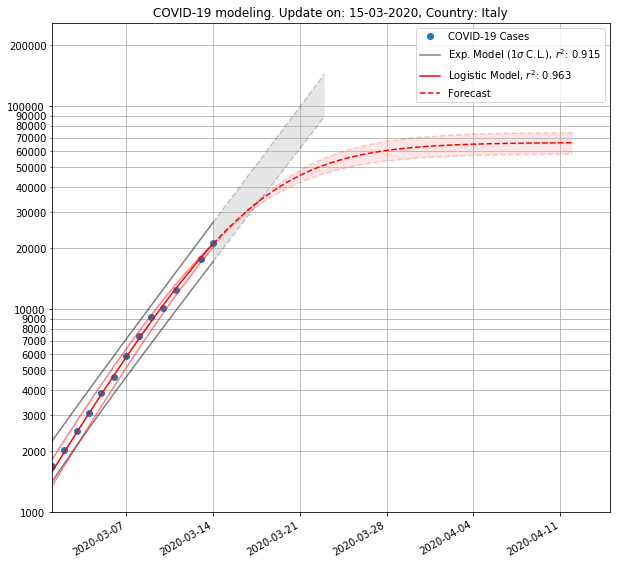

In [13]:
# Draw
_,ax = plt.subplots(figsize=(10,10))
logy=True
# Data
dfit.plot('Date', 'Cases', marker='o', linestyle="None", label='COVID-19 Cases', ax=ax, logy=logy)

# Exponential Model
#df_predict_exp.plot('Date', 'Model', color='k', linestyle='-', alpha=1, label='_nolegend_', ax=ax)
df_predict_exp.plot('Date', 'Model_sup', color='k', linestyle='-', alpha=0.5, label='Exp. Model ($1\sigma$ C.L.), $r^2$: %.3f'% r_square_exp, ax=ax)
df_predict_exp.plot('Date', 'Model_inf', color='k', linestyle='-', alpha=0.5, label='_nolegend_', ax=ax)
# Exponential Model Forecast
#df_forecast_exp.plot('Date', 'Forecast', color='k', linestyle='--', alpha=1, label='_nolegend_', ax=ax)
df_forecast_exp.plot('Date', 'Forecast_sup', color='k', linestyle='--', alpha=0.2, label='_nolegend_', ax=ax)
df_forecast_exp.plot('Date', 'Forecast_inf', color='k', linestyle='--', alpha=0.2, label='_nolegend_', ax=ax)
ax.fill_between(df_forecast_exp['Date'], df_forecast_exp['Forecast_inf'], df_forecast_exp['Forecast_sup'], facecolor="k", alpha=0.1)

# Logistic Model
df_predict_logit.plot('Date', 'Model', color='r', linestyle='-', alpha=1, label='Logistic Model, $r^2$: %.3f'% r_square_logit, ax=ax)
df_predict_logit.plot('Date', 'Model_sup', color='r', linestyle='-', alpha=0.5, label='_nolegend_', ax=ax)
df_predict_logit.plot('Date', 'Model_inf', color='r', linestyle='-', alpha=0.5, label='_nolegend_', ax=ax)
# Logistic Model Forecast
df_forecast_logit.plot('Date', 'Forecast', color='r', linestyle='--', alpha=1, label='Forecast', ax=ax)
df_forecast_logit.plot('Date', 'Forecast_sup', color='r', linestyle='--', alpha=0.2, label='_nolegend_', ax=ax)
df_forecast_logit.plot('Date', 'Forecast_inf', color='r', linestyle='--', alpha=0.2, label='_nolegend_', ax=ax)
ax.fill_between(df_forecast_logit['Date'], df_forecast_logit['Forecast_inf'], df_forecast_logit['Forecast_sup'], facecolor="red", alpha=0.1)

formatter = matplotlib.ticker.ScalarFormatter()
formatter.set_scientific(False)
ax.yaxis.set_minor_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

from datetime import datetime    
plt.title('COVID-19 modeling. Update on: %s, Country: %s' %(datetime.today().strftime('%d-%m-%Y'),dfit['Country/Region'].values[0]))
plt.grid(axis='both',which='both')
plt.xlabel('')

#Axis limit
ax.set_xlim(['2020-03-01','2020-04-15'])
ax.set_ylim([1000, None])

plt.show()

## Logistic model: forecast 30 days ahead

In [11]:
display(df_forecast_logit)

,Date,Forecast,Forecast_sup,Forecast_inf,Uncertainty
43,2020-03-14,20947.209906,20166.807898,21082.217670,-915.409772
44,2020-03-15,24273.023393,23709.091754,24087.663444,-378.571690
45,2020-03-16,27801.627953,27555.991665,27206.250337,349.741328
46,2020-03-17,31457.993488,31636.185890,30368.384571,1267.801319
47,2020-03-18,35155.175346,35856.831276,33500.500818,2356.330457
48,2020-03-19,38802.290312,40111.203971,36531.780058,3579.423912
49,2020-03-20,42313.277475,44289.143716,39400.347680,4888.796036
50,2020-03-21,45614.700419,48288.220568,42057.846560,6230.374007
51,2020-03-22,48651.162244,52023.292049,44471.764592,7551.527457
52,2020-03-23,51387.642484,55432.671187,46625.492596,8807.178591
